# Trabajo Práctico de Laboratorio 1
## Teoría moderna y filtrado activo
### Renata Salvati Dávila
***

<img src="./Especificaciones.png" align="center" width="800" /> 

## Obtención del orden del filtro

In [2]:
# Inicialización e importación de módulos

# Módulos externos
import numpy as np
import scipy.signal as sig
import matplotlib as mpl

from matplotlib import pyplot as plt
from pytc2.sistemas_lineales import analyze_sys, pretty_print_lti, bodePlot, pzmap, tf2sos_analog, pretty_print_SOS

fig_sz_x = 13
fig_sz_y = 7
fig_dpi = 80 # dpi
fig_font_size = 13

mpl.rcParams['figure.figsize'] = (fig_sz_x, fig_sz_y)
mpl.rcParams['figure.dpi'] = fig_dpi
plt.rcParams.update({'font.size':fig_font_size})

In [8]:
#Datos de enunciado
d = 80*(10**-6)

f1 = 3*(10**3)
f2 = 2*(10**3)

nf = 1/d

w1_n = (2*np.pi*f1)/nf
w2_n = (2*np.pi*f2)/nf

print(f"Las frecuencias angulares normalizadas son:\nw1 = {w1_n} w2 = {w2_n}")

Las frecuencias angulares normalizadas son:
w1 = 1.5079644737231004 w2 = 1.0053096491487337


Con las frecuencias ya normalizadas y las curvas de diseño, se busca ahora el orden del filtro que corresponde a cada especificación del enunciado
<img src="./Curvas de diseño.png" align="center" width="900" />
Se puede ver que en ambos casos coincide que el orden es 3.

<IPython.core.display.Math object>

<IPython.core.display.Math object>

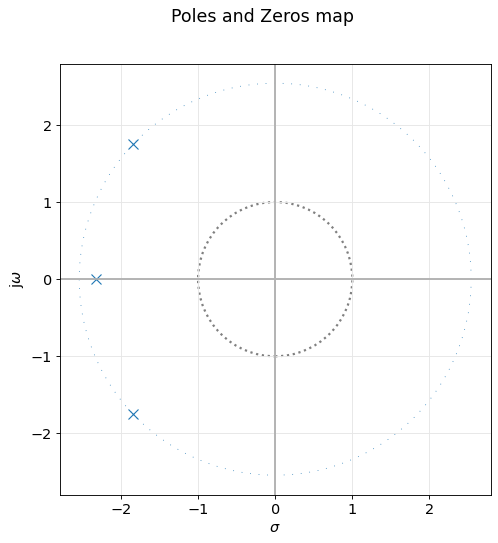

In [14]:
n = 3

z,p,k = sig.besselap(n, 'delay')
num, den = sig.zpk2tf(z, p, k)

H = sig.TransferFunction(num, den)
pretty_print_lti(num, den)

SOS_H = tf2sos_analog(num, den)
pretty_print_SOS(SOS_H, 'omegayq')

pzmap(H);

In [11]:
a_max = 1
a_min = 12

fp = 1500
fs = 3000

nf = 2*np.pi*fp #norma de frecuencia

wf = (2*np.pi*fp)/nf
ws = (2*np.pi*fs)/nf

#Obtención de epsilon y n
e2 = 10**(a_max/10) - 1

for aux_n in range(2,5):
    aux_a_min = 10*np.log10(1 + e2*ws**(2*aux_n))
    
    if aux_a_min > a_min:
        n = aux_n
        break

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [21]:
nf2 = e2**(-1/2/n) #segunda norma de frecuencia (e⁻(1/n))

#Obtención de la transferencia
z, p, k = sig.buttap(n)
num, den = sig.zpk2tf(z, p, k)
num_n, den_n = sig.lp2lp(num, den, nf2) #polinomios renormalizados con wb

H = sig.TransferFunction(num, den)
H_n = sig.TransferFunction(num_n, den_n)

display(H)
pretty_print_lti(num, den)

display(H_n)
pretty_print_lti(num_n, den_n)

TransferFunctionContinuous(
array([1.]),
array([1., 2., 2., 1.]),
dt: None
)

<IPython.core.display.Math object>

TransferFunctionContinuous(
array([1.96522673]),
array([1.        , 2.50515278, 3.13789522, 1.96522673]),
dt: None
)

<IPython.core.display.Math object>

**2. Obtener el diagrama de polos y ceros, y un bosquejo de la respuesta en frecuencia.**
<img src="./Diagrama.jpeg" align="center" width="900" /> 

Graficando desde Python:

(2, <Axes: xlabel='$\\sigma$', ylabel='j$\\omega$'>)

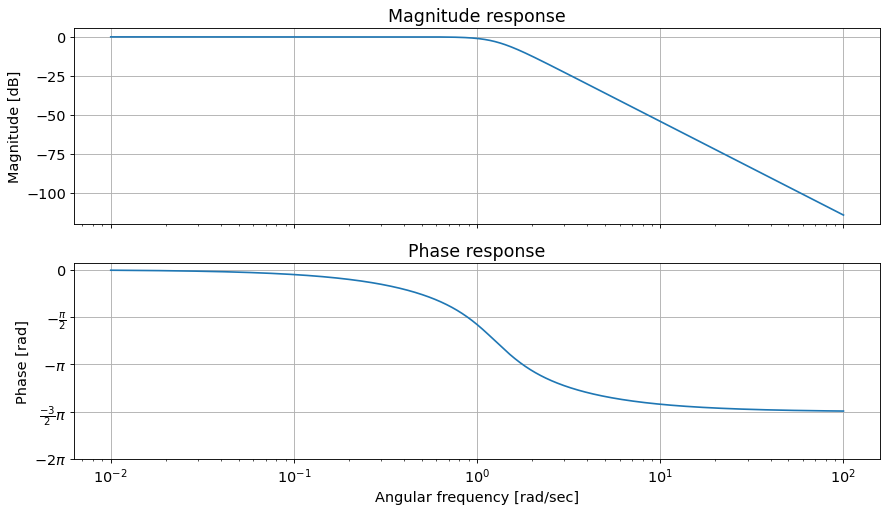

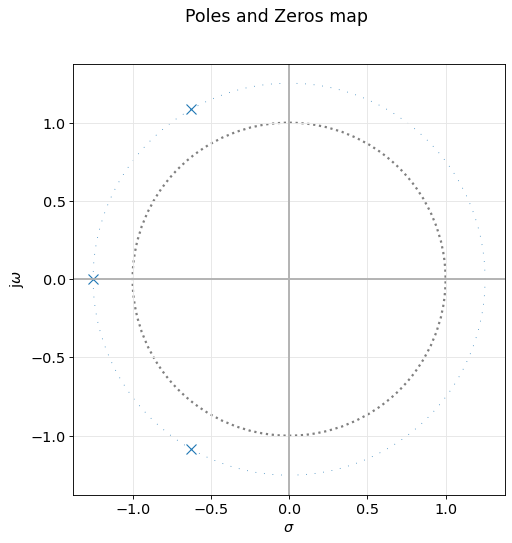

In [22]:
bodePlot(H_n)
pzmap(H_n)

**3. Implementar el circuito normalizado con estructuras pasivas separadas mediante buffers.**

<img src="./Normalización.jpeg" align="center" width="800" /> 

In [23]:
#Fijo el valor de los valores normalizados de los capacitores
C1_ = 1.0
C2_ = 1.0

L1_ = 1/C1_
R1_ = L1_
R2_ = 1/C2_

print(f"Valores de los componentes normalizados: \nC1_ = {C1_}, C2_ = {C2_}, L1_ = {L1_}, R1_ = {R1_}, R2_ = {R2_}")

Valores de los componentes normalizados: 
C1_ = 1.0, C2_ = 1.0, L1_ = 1.0, R1_ = 1.0, R2_ = 1.0


<img src="./Circuito normalizado.png" align="center" width="800" /> 

**4. Obtenga el circuito que cumpla con la plantilla requerida si dispone de capacitores de 100nF.**

<img src="./Componentes.jpeg" align="center" width="800" />

In [24]:
#Desnormalizo los valores sabiendo que necesito capacitores de 100nF
C1 = 100 * (10**-9)
C2 = 100 * (10**-9)

ni = 1/(C1*nf*nf2) #norma de impedancia

L1 = (L1_ * ni)/(nf*nf2)
R1 = ni
R2 = ni

print(f"Valores de los componentes normalizados: \nC1 = {C1}, C2 = {C2},\nL1 = {L1}, R1 = {R1}, R2 = {R2}")

Valores de los componentes normalizados: 
C1 = 1.0000000000000001e-07, C2 = 1.0000000000000001e-07,
L1 = 0.07175452663013715, R1 = 847.0804367363063, R2 = 847.0804367363063


<img src="./Circuito.png" align="center" width="800" /> 
<img src="./Simulación.png" align="center" width="1000" /> 

**5. Proponga una red que se comporte igual a la hallada en 4) pero con resistores, capacitores y opamps.**

<img src="./Activación.jpeg" align="center" width="900" /> 

Utilizo una transformación de Bruton en la primer etapa para luego activar el circuito con un FDNR.

In [25]:
#Nuevos componentes por la transformación (normalizados)

C_ = 1/R1_
R_ = L1_
D_ = C1_

print(f"Valores de los componentes normalizados: \nC_ = {C_}, R_ = {R_}, D_ = {D_}")

#FDNR (D = C*R²)

Cfdnr_ = 1.0
Rfdnr_ = np.sqrt(D_/Cfdnr_)

Valores de los componentes normalizados: 
C_ = 1.0, R_ = 1.0, D_ = 1.0


In [26]:
#Desnormalización

Cfdnr = 100 * (10**-9)
Rfdnr = ni

Z3 = Z5 = Cfdnr
Z1 = Z2 = Z4 = Rfdnr

print(f"Valores de los componentes del FDNR desnormalizados: \nZ1 = {Z1}, Z2 = {Z2}, Z3 = {Z3}, \nZ4 = {Z4}, Z5 = {Z5}")

Valores de los componentes del FDNR desnormalizados: 
Z1 = 847.0804367363063, Z2 = 847.0804367363063, Z3 = 1.0000000000000001e-07, 
Z4 = 847.0804367363063, Z5 = 1.0000000000000001e-07


<img src="./Circuito activo.png" align="center" width="800" /> 
<img src="./Simulación activa.png" align="center" width="1000" /> 